In [170]:
#Import libraries

#basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

#nlp
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
# !pip3 install emoji
import emoji
from nltk.tokenize import sent_tokenize, word_tokenize
# nltk.download('punkt')
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
# nltk.download('averaged_perceptron_tagger')

#ml
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score


In [171]:
df = pd.read_csv('airlines_reviews.csv')
display(df.head(5), df.shape)


,Title,Name,Review Date,Airline,Verified,Reviews,Type of Traveller,Month Flown,Route,Class,Seat Comfort,Staff Service,Food & Beverages,Inflight Entertainment,Value For Money,Overall Rating,Recommended
0,Flight was amazing,Alison Soetantyo,2024-03-01,Singapore Airlines,True,Flight was amazing. The crew onboard this fl...,Solo Leisure,December 2023,Jakarta to Singapore,Business Class,4,4,4,4,4,9,yes
1,seats on this aircraft are dreadful,Robert Watson,2024-02-21,Singapore Airlines,True,Booking an emergency exit seat still meant h...,Solo Leisure,February 2024,Phuket to Singapore,Economy Class,5,3,4,4,1,3,no
2,Food was plentiful and tasty,S Han,2024-02-20,Singapore Airlines,True,Excellent performance on all fronts. I would...,Family Leisure,February 2024,Siem Reap to Singapore,Economy Class,1,5,2,1,5,10,yes
3,“how much food was available,D Laynes,2024-02-19,Singapore Airlines,True,Pretty comfortable flight considering I was f...,Solo Leisure,February 2024,Singapore to London Heathrow,Economy Class,5,5,5,5,5,10,yes
4,“service was consistently good”,A Othman,2024-02-19,Singapore Airlines,True,The service was consistently good from start ...,Family Leisure,February 2024,Singapore to Phnom Penh,Economy Class,5,5,5,5,5,10,yes


(8100, 17)

## EDA

In [172]:
# No of reviews per airline
df[['Reviews','Airline']].groupby(['Airline']).count().sort_values(by = 'Airline', ascending= False).reset_index()

,Airline,Reviews
0,Turkish Airlines,1685
1,Singapore Airlines,972
2,Qatar Airways,1624
3,Korean Air,187
4,Japan Airlines,201
5,Emirates,1350
6,EVA Air,281
7,Cathay Pacific Airways,744
8,All Nippon Airways,258
9,Air France,798


,Airline,Overall Rating
0,All Nippon Airways,7.949612
1,EVA Air,7.419929
2,Qatar Airways,7.195813
3,Japan Airlines,7.099502
4,Singapore Airlines,6.542181
5,Korean Air,6.491979
6,Cathay Pacific Airways,6.169355
7,Emirates,4.674074
8,Air France,4.637845
9,Turkish Airlines,3.679525


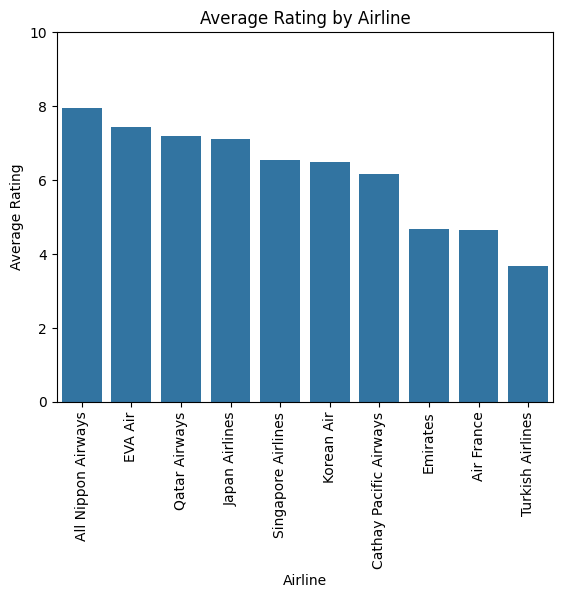

In [173]:
# Avg rating by airline
df_temp = df[['Overall Rating','Airline']].groupby(['Airline']).mean().sort_values(by = 'Overall Rating', ascending= False).reset_index()
display(df_temp)
sns.barplot(data= df_temp, x='Airline', y='Overall Rating')

plt.ylim(0, 10) 
plt.xticks(rotation=90) 
plt.xlabel('Airline')
plt.ylabel('Average Rating')
plt.title('Average Rating by Airline')
plt.show()

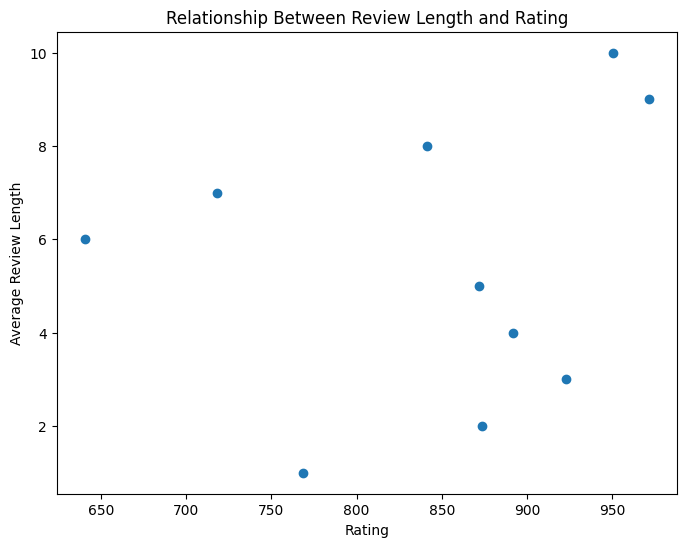

In [174]:
#Relationship Between Review Length and Rating
df['review_length'] = df['Reviews'].str.len()

plt.figure(figsize=(8, 6))
plt.scatter(df.groupby('Overall Rating')['review_length'].mean(), df['Overall Rating'].unique())
plt.xlabel('Rating')
plt.ylabel('Average Review Length')
plt.title('Relationship Between Review Length and Rating')
plt.show()

In [175]:
#Relationship Between Date and Rating

#chnaging data type of date column
df['Review Date'] = pd.to_datetime(df['Review Date'])

df[['Overall Rating']].groupby(df['Review Date'].dt.year).mean().reset_index()

,Review Date,Overall Rating
0,2016,6.861042
1,2017,6.652857
2,2018,5.769747
3,2019,5.374743
4,2020,5.040850
5,2021,4.671171
6,2022,4.762009
7,2023,5.080041
8,2024,4.926471


## 3. Preprocessing

In [176]:
X = df['Reviews']
y = df['Overall Rating']

### 3.1 Word level Preprocessing

In [177]:

def word_level_preprocessing(text):
    # Convert text to lowercase
    text = text.astype(str).str.lower()
    # Remove emojis
    text = text.apply(lambda x: emoji.demojize(x))
    text = text.str.replace(r':[a-z_]+:', ' ', regex=True)
    # Remove special characters and numbers
    text = text.str.replace(r'[^a-zA-Z\s]', '', regex=True)
    # Tokenization (split the text into words)
    words = text.str.split()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = words.apply(lambda x: [word for word in x if word not in stop_words])
    # Stemming
    stemmer = PorterStemmer()
    words = words.apply(lambda x: [stemmer.stem(word) for word in x])
    # Join the words back into a single string
    preprocessed_text = words.str.join(' ')
    return preprocessed_text

### 3.2 Sentence level Preprocessing

In [178]:

def sentence_level_preprocessing(text):
     # Convert text to lowercase
    text = text.astype(str).str.lower()
    # Remove emojis
    text = text.apply(lambda x: emoji.demojize(x))
    text = text.str.replace(r':[a-z_]+:', ' ', regex=True)
    # Remove special characters and numbers
    text = text.str.replace(r'[^a-zA-Z\s]', '', regex=True)
    # Tokenization (split the text into sentences)
    sentences = text.apply(lambda x: sent_tokenize(x))
    # Flatten list of sentences
    sentences = sentences.explode()
    
    # POS Tagging
    tagged_sentences = sentences.apply(word_tokenize).apply(pos_tag)
    
    # Parse for sentiment analysis
    
    # Tokenization (split the sentences into words)
    words = tagged_sentences.apply(lambda x: [word for word, tag in x if word not in stopwords.words('english')])
    
    # Stemming
    stemmer = PorterStemmer()
    words = words.apply(lambda x: [stemmer.stem(word) for word in x])
    
    # Join the words back into a single string
    preprocessed_text = words.str.join(' ')
    return preprocessed_text

## Modeling

### 2.1 Random Forest Regressor

In [130]:
# Preprocess text data
# X_preprocessed = word_level_preprocessing(X)
X_preprocessed = sentence_level_preprocessing(X)


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Vectorize preprocessed text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # You can adjust max_features as needed
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train Random Forest model
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest.fit(X_train_tfidf, y_train)


# Predict ratings
y_pred = random_forest.predict(X_test_tfidf)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 4.469158888888888


### 2.2 Random Forest Classifier with 10 CV

In [143]:
# defining train and test sets
X = df['Reviews']
y = df['Overall Rating'].apply(lambda x: 1 if x >= 6.9 and x <= 11 else
                                    0 if x >= 4.0 and x <= 6.1 else
                                    -1 )
y.value_counts()

# Preprocess text data
X_preprocessed = sentence_level_preprocessing(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Vectorize preprocessed text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # You can adjust max_features as needed
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

#perform 10 fold cv 
val_scores = cross_val_score(rf_model,X_train_tfidf,y_train, cv = 10,scoring= 'accuracy')

# Print the mean accuracy and standard deviation
print("Mean val Accuracy:", val_scores.mean())
print("Val Standard Deviation:", val_scores.std())

# Predict ratings
y_pred = rf_model.predict(X_test_tfidf)

#predictions accuracy
acc = accuracy_score(y_test.values.reshape(-1, 1), y_pred)
print('prdiction accuracy:', acc)


Mean val Accuracy: 0.783179012345679
Val Standard Deviation: 0.013044460159879109
prdiction accuracy: 0.7814814814814814


### 3.0 Logistic Regression 

In [183]:
# defining train and test sets
X = df['Reviews']
y = df['Overall Rating'].apply(lambda x: 1 if x >= 6.9 and x <= 11 else
                                    0 if x >= 4.0 and x <= 6.1 else
                                    -1 )
print(y.value_counts())

# Preprocess text data
X_preprocessed = sentence_level_preprocessing(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Vectorize preprocessed text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train Random Forest model
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(penalty = 'l2', C = 1.8976381856548117, max_iter = 353, multi_class='ovr', solver='lbfgs', random_state=42)
lr_model.fit(X_train_tfidf, y_train)

#perform 10 fold cv 
val_scores = cross_val_score(lr_model,X_train_tfidf,y_train, cv = 3,scoring= 'accuracy')

# Print the mean accuracy and standard deviation
print("Mean val Accuracy:", val_scores.mean())
print("Val Standard Deviation:", val_scores.std())

# Predict ratings
y_pred = lr_model.predict(X_test_tfidf)

#predictions accuracy
acc = accuracy_score(y_test.values.reshape(-1, 1), y_pred)
print('prdiction accuracy:', acc)

Overall Rating
 1    3915
-1    3022
 0    1163
Name: count, dtype: int64
Mean val Accuracy: 0.8018518518518518
Val Standard Deviation: 0.011899739289294425
prdiction accuracy: 0.8037037037037037


#### 3.1 Hyperparameter Optimisation Logistic Regression 

In [181]:
# import optuna
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import accuracy_score
# from sklearn.linear_model import LogisticRegression
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.model_selection import train_test_split

# # defining train and test sets
# X = df['Reviews']
# y = df['Overall Rating'].apply(lambda x: 1 if x >= 6.9 and x <= 11 else
#                                     0 if x >= 4.0 and x <= 6.1 else
#                                     -1 )
# print(y.value_counts())

# # Preprocess text data
# X_preprocessed = sentence_level_preprocessing(X)

# # Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# # Define objective function for Optuna
# def objective(trial):
#     # Define hyperparameters to optimize
#     penalty = trial.suggest_categorical('penalty', ['l2'])  # Regularization type
#     C = trial.suggest_loguniform('C', 0.001, 10)  # Regularization strength
#     max_iter = trial.suggest_int('max_iter', 100, 1000)  # Maximum number of iterations
#     class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])  # Class weights
    
#     # Train Logistic Regression model with hyperparameters
#     lr_model = LogisticRegression(multi_class='ovr', solver='lbfgs', penalty=penalty, C=C, max_iter=max_iter,
#                                   class_weight=class_weight, random_state=42)
#     val_scores = cross_val_score(lr_model, X_train_tfidf, y_train, cv=5, scoring='accuracy')
    
#     # Return mean validation accuracy as the objective value to maximize
#     return val_scores.mean()

# # Optimize hyperparameters using Optuna
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# # Get the best hyperparameters
# best_params = study.best_params
# print(best_params)

# # Train Logistic Regression model with best hyperparameters
# lr_model = LogisticRegression(multi_class='ovr', solver='lbfgs', **best_params, random_state=42)
# lr_model.fit(X_train_tfidf, y_train)

# # Predict ratings
# y_pred = lr_model.predict(X_test_tfidf)

# # Calculate accuracy
# acc = accuracy_score(y_test, y_pred)
# print('Prediction accuracy:', acc)

# #best acc 80.37

Overall Rating
 1    3915
-1    3022
 0    1163
Name: count, dtype: int64


[I 2024-04-28 17:58:35,147] A new study created in memory with name: no-name-05f891c6-9a0a-4730-8e3c-1538d9cbf765
/var/folders/yj/2fr85zvn2sbbpv3jsq4y3kwh0000gn/T/ipykernel_5316/1774006226.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.001, 10)  # Regularization strength
[I 2024-04-28 17:58:36,014] Trial 0 finished with value: 0.7725308641975308 and parameters: {'penalty': 'l2', 'C': 5.3225364310590635, 'max_iter': 103, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7725308641975308.
/var/folders/yj/2fr85zvn2sbbpv3jsq4y3kwh0000gn/T/ipykernel_5316/1774006226.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = tri

Prediction accuracy: 0.8037037037037037


## Deep learning

In [152]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.utils import to_categorical

# train and test sets
X = df['Reviews']
y = df['Overall Rating']
# Convert overall ratings to sentiment categories
df['Overall Rating'] = df['Overall Rating'].apply(lambda x: 1 if x >= 6.9 and x <= 11 else
                                                  0 if x >= 4.0 and x <= 6.1 else
                                                  -1)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['Reviews'], df['Overall Rating'], test_size=0.2, random_state=42)

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Reviews'])
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform length
max_length = max([len(seq) for seq in X_train + X_test])
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')

# Reshape the target variables
y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

# Define the model
embedding_dim = 50
vocab_size = len(tokenizer.word_index) + 1

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/10
137/203 [===================>..........] - ETA: 1:59 - loss: -18.9395 - accuracy: 0.0000e+00

KeyboardInterrupt: 

In [169]:
l1 = [1,2,3]
l1_array = np.array(l1)
l1_array
l1_array.reshape(-1, 1)

array([[1],
       [2],
       [3]])